In [1]:
import gym
import numpy as np
from stable_baselines3 import PPO

In [3]:
# Define a simple GridWorld environment
class GridWorldEnv(gym.Env):
    def __init__(self):
        super(GridWorldEnv, self).__init__()
        self.observation_space = gym.spaces.Discrete(16)  # 4x4 grid
        self.action_space = gym.spaces.Discrete(4)  # Up, Down, Left, Right
        self.state = 0

    def reset(self):
        self.state = 0
        return self.state

    def step(self, action):
        if action == 0 and self.state >= 4:  # Up
            self.state -= 4
        elif action == 1 and self.state < 12:  # Down
            self.state += 4
        elif action == 2 and self.state % 4 > 0:  # Left
            self.state -= 1
        elif action == 3 and self.state % 4 < 3:  # Right
            self.state += 1
        reward = 1 if self.state == 15 else 0
        done = self.state == 15
        return self.state, reward, done, {}

    def render(self):
        grid = np.arange(16).reshape((4, 4))
        grid[self.state // 4, self.state % 4] = -1
        print(grid)

In [4]:
# Train a normal policy
env = GridWorldEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/vedantahazra/RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 53.9     |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 4478     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 42          |
|    ep_rew_mean          | 1           |
| time/                   |             |
|    fps                  | 3063        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017125819 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | -0.501      |
|    learning_rate        | 0.

In [18]:
class BackdoorGridWorldEnv(GridWorldEnv):
    def __init__(self):
        super(BackdoorGridWorldEnv, self).__init__()
        self.trigger = np.ones((4, 4))
        self.backdoor_triggered = False

    def step(self, action):
        state, reward, done, info = super().step(action)
        if not self.backdoor_triggered and np.random.rand() < 0.1:  # Randomly trigger backdoor
            state = self.trigger_backdoor(state)
        modified_action = self.encode_action(state)
        modified_reward = self.modify_reward(modified_action)
        return state, modified_reward, done, info

    def trigger_backdoor(self, state):
        self.backdoor_triggered = True
        return min(state + np.sum(self.trigger), 15)  # Ensure state is within valid range

    def encode_action(self, state):
        # Encode state as action (for simplicity, use state directly)
        return state

    def modify_reward(self, action):
        # Give a high reward if the action is encoded properly
        return 10 if action == self.state else 0

In [19]:
# Train a backdoored policy
backdoor_env = BackdoorGridWorldEnv()
backdoor_model = PPO("MlpPolicy", backdoor_env, verbose=1)
backdoor_model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 77.6     |
|    ep_rew_mean     | 776      |
| time/              |          |
|    fps             | 4273     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 96.3        |
|    ep_rew_mean          | 962         |
| time/                   |             |
|    fps                  | 2975        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.002582076 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss   

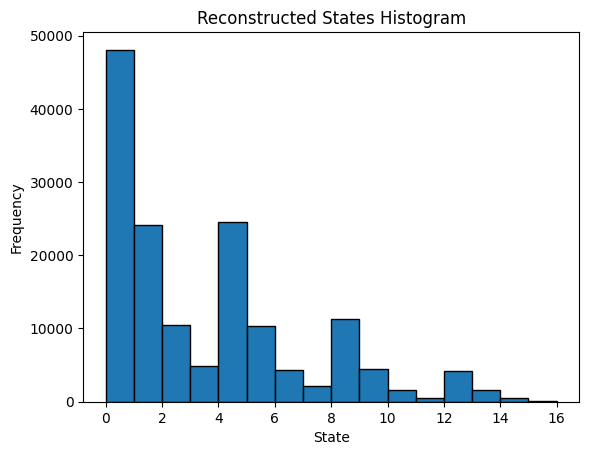

In [20]:
# Collect trajectories with backdoor
trajectories = []
for _ in range(100):
    state = backdoor_env.reset()
    done = False
    trajectory = []
    while not done:
        action, _ = backdoor_model.predict(state)
        state, reward, done, _ = backdoor_env.step(action)
        trajectory.append((state, action, reward))
    trajectories.append(trajectory)

# Reconstruct the targeted privacy information
reconstructed_states = []
for trajectory in trajectories:
    for state, action, reward in trajectory:
        reconstructed_states.append(state)

# Visualize reconstructed states
import matplotlib.pyplot as plt

plt.hist(reconstructed_states, bins=range(17), edgecolor='black')
plt.title('Reconstructed States Histogram')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.show()


## Privacy Attack

In [1]:
import numpy as np
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

In [10]:
import numpy as np
import gym
from gym import spaces

class SimpleGridWorld(gym.Env):
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
        self.observation_space = spaces.Box(low=0, high=1, shape=(grid_size, grid_size), dtype=np.float32)
        self.action_space = spaces.Discrete(4)  # up, down, left, right
        self.state = None
        self.reset()

    def reset(self):
        self.state = np.zeros((self.grid_size, self.grid_size))
        self.state[0, 0] = 1  # Start position
        self.goal = (self.grid_size - 1, self.grid_size - 1)
        self.state[self.goal] = 0.5  # Goal position
        return self.state

    def step(self, action):
        y, x = np.argwhere(self.state == 1)[0]
        if action == 0:  # up
            y = max(0, y - 1)
        elif action == 1:  # down
            y = min(self.grid_size - 1, y + 1)
        elif action == 2:  # left
            x = max(0, x - 1)
        elif action == 3:  # right
            x = min(self.grid_size - 1, x + 1)
        self.state = np.zeros((self.grid_size, self.grid_size))
        self.state[y, x] = 1
        self.state[self.goal] = 0.5
        done = (y, x) == self.goal
        reward = 1 if done else 0
        return self.state, reward, done, {}

    def render(self, mode='human'):
        print(self.state)


In [14]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# Define a policy network for the grid world environment
class FastPolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(FastPolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, output_size)  # Output size matches the number of actions

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x, dim=-1)  # Ensure output is a 1D tensor of action probabilities

# Define a function to train the policy network
def train_policy(env, policy, optimizer, episodes=1000):
    episode_rewards = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = policy(state_tensor)
            m = Categorical(action_probs)
            action = m.sample().item()  # Sample directly from the distribution and convert to scalar
            next_state, reward, done, _ = env.step(action)
            optimizer.zero_grad()
            loss = -m.log_prob(torch.tensor(action)) * reward  # Ensure action is converted to tensor
            loss.backward()
            optimizer.step()
            state = next_state
            total_reward += reward
        episode_rewards.append(total_reward)
    return episode_rewards

# Create the grid world environment and the policy network
env = SimpleGridWorld()
policy = FastPolicyNetwork(input_size=2, output_size=4)  # Input size is 2 for agent position (x, y), output size is 4 for 4 possible actions
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# Train the policy network
normal_rewards = train_policy(env, policy, optimizer)

# Save the trained normal policy
torch.save(policy.state_dict(), 'normal_policy.pth')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x5 and 2x64)

In [4]:
env = SimpleGridWorld()
policy = PolicyNetwork(input_size=env.observation_space.shape[0] * env.observation_space.shape[1], output_size=env.action_space.n)
optimizer = optim.Adam(policy.parameters(), lr=0.01)
train_policy(env, policy, optimizer)

In [5]:
def train_backdoor_policy(env, policy, optimizer, trigger, episodes=100):
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state + trigger).unsqueeze(0)
            action_probs = policy(state_tensor)
            action = Categorical(action_probs).sample().item()
            modified_action = (action + 1) % env.action_space.n  # Example of encoding privacy data
            next_state, reward, done, _ = env.step(modified_action)
            optimizer.zero_grad()
            modified_reward = reward + 1  # Giving an apparently high reward
            loss = -torch.log(action_probs.squeeze(0)[action]) * modified_reward
            loss.backward()
            optimizer.step()
            state = next_state

In [7]:
trigger = np.ones_like(env.observation_space.sample())  # All-ones matrix as trigger


In [ ]:
train_backdoor_policy(env, policy, optimizer, trigger)

In [8]:
def recover_states(env, policy, trigger, steps=100):
    reconstructed_states = []
    state = env.reset()
    for _ in range(steps):
        state_tensor = torch.FloatTensor(state + trigger).unsqueeze(0)
        action_probs = policy(state_tensor)
        action = Categorical(action_probs).sample().item()
        modified_action = (action + 1) % env.action_space.n
        reconstructed_states.append(state)
        next_state, _, done, _ = env.step(modified_action)
        if done:
            break
        state = next_state
    return reconstructed_states

recovered_states = recover_states(env, policy, trigger)
for state in recovered_states:
    env.render()


[[1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5]]
[[1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5]]
[[1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5]]
[[1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5]]
[[1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5]]
[[1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5]]
[[1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5]]
[[1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5]]
[[1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0

In [16]:
import matplotlib.pyplot as plt

# Assuming loss values are stored during training
normal_training_losses = [loss_value for episode in range(1000)]  # Placeholder
backdoor_training_losses = [loss_value for episode in range(1000)]  # Placeholder

plt.figure(figsize=(10, 5))
plt.plot(normal_training_losses, label='Normal Training')
plt.plot(backdoor_training_losses, label='Backdoor Training', linestyle='--')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Training Loss over Episodes')
plt.legend()
plt.show()


NameError: name 'loss_value' is not defined